In [12]:

from pathlib import Path
import torch
import sys
sys.path.insert(0, "..")   
from src.data_utils import load_raw_data, load_full_data, load_X_y_data, create_sale_features,build_feature_and_label_cols
from src.data_utils import combine_loaders_to_dataframe
import torch


In [4]:
%reload_ext autoreload
%autoreload 2

In [29]:
#df = load_raw_data(Path("../output/data/train_top_store_15_item.parquet"))
df = load_raw_data(Path("../output/data/sale_features_cluster_0_10.parquet"))
df.head()

2025-07-24 13:24:57,192 - INFO - Loading data from ../output/data/sale_features_cluster_0_10.parquet


2025-07-24 13:24:57,396 - ERROR - Error loading data: "['date', 'unit_sales', 'onpromotion'] not in index"


KeyError: "['date', 'unit_sales', 'onpromotion'] not in index"

In [32]:
df = pd.read_parquet("../output/data/sale_features_cluster_0_10.parquet")
df.sort_values(["store_item", "start_date"], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,start_date,store_item,store,item,store_cluster,item_cluster,weight,store_med_day_1,item_med_day_1,store_med_change_1,item_med_change_1,store_med_logpct_change_1,item_med_logpct_change_1,sales_day_1
0,2014-01-01,23_1004551,23,1004551,0,10,1,0.0,0.0,0.000000,0.000000,-6.907755,-6.907755,0.0
1,2014-01-02,23_1004551,23,1004551,0,10,1,7.0,7.0,0.285714,0.285714,-1.252763,-1.252763,2.0
2,2014-01-03,23_1004551,23,1004551,0,10,1,6.0,6.0,1.000000,1.000000,0.000000,0.000000,6.0
3,2014-01-04,23_1004551,23,1004551,0,10,1,7.0,7.0,1.857143,1.857143,0.619039,0.619039,13.0
4,2014-01-05,23_1004551,23,1004551,0,10,1,7.0,7.0,0.000000,0.000000,-6.907755,-6.907755,0.0


In [33]:
df.to_csv("../output/data/store_0_item_10_cluster.csv", index=False)

In [31]:
df

,start_date,store_item,store,item,store_cluster,item_cluster,weight,store_med_day_1,item_med_day_1,store_med_change_1,item_med_change_1,store_med_logpct_change_1,item_med_logpct_change_1,sales_day_1
0,2014-01-01,5_108831,5,108831,0,10,1,0.000,0.000,0.000000,0.000000,-6.907755,-6.907755,0.000000
1,2014-01-01,5_265086,5,265086,0,10,1,0.000,0.000,0.000000,0.000000,-6.907755,-6.907755,0.000000
2,2014-01-01,5_268443,5,268443,0,10,1,0.000,0.000,0.000000,0.000000,-6.907755,-6.907755,0.000000
3,2014-01-01,5_268664,5,268664,0,10,1,0.000,0.000,0.000000,0.000000,-6.907755,-6.907755,0.000000
4,2014-01-01,5_315178,5,315178,0,10,1,0.000,0.000,0.000000,0.000000,-6.907755,-6.907755,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170347,2015-12-31,41_1695873,41,1695873,0,10,1,5.607,5.607,2.496879,2.496879,0.915042,0.915042,14.000000
170348,2015-12-31,41_1695931,41,1695931,0,10,1,5.607,5.607,14.164972,14.164972,2.650772,2.650772,79.422997
170349,2015-12-31,41_1695950,41,1695950,0,10,1,5.607,5.607,4.371857,4.371857,1.475188,1.475188,24.513000
170350,2015-12-31,41_1696003,41,1696003,0,10,1,5.607,5.607,0.762618,0.762618,-0.270998,-0.270998,4.276000


In [61]:
df["weight"].unique()

array([0., 1.], dtype=float32)

In [62]:
df.dtypes

date             datetime64[ns]
store_item               object
store                     int64
item                      int64
unit_sales              float32
onpromotion              object
weight                  float32
id                      float64
store_cluster            object
item_cluster             object
cluster                  object
dtype: object

In [63]:
df2 = df.query("store_cluster == '0' and item_cluster == '0'")
df2.sort_values(["store_item", "date"], inplace=True)
df2.reset_index(drop=True, inplace=True)
df2.to_csv("../output/data/train_store_cluster_0_item_cluster_0.csv", index=False)

/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_27498/370175656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_values(["store_item", "date"], inplace=True)


In [64]:
df2.head()

,date,store_item,store,item,unit_sales,onpromotion,weight,id,store_cluster,item_cluster,cluster
0,2014-01-01,0,32,1331407,0.0,0,0.0,0.0,0,0,0_0
1,2014-01-01,0,32,1245918,0.0,0,0.0,0.0,0,0,0_0
2,2014-01-01,0,32,1463935,0.0,0,0.0,0.0,0,0,0_0
3,2014-01-01,0,32,743497,0.0,0,0.0,0.0,0,0,0_0
4,2014-01-01,0,32,1143686,0.0,0,0.0,0.0,0,0,0_0


In [67]:
df3 = create_sale_features(
        df2,
        window_size=1,
        calendar_aligned=True,
        fn=None,
        log_level="DEBUG",
    )

2025-07-19 15:16:24,538 - INFO - Generating sales features
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/utils.py:600: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Lookup dictionaries
2025-07-19 15:16:24,542 - DEBUG - Generating lookup dictionaries
2025-07-19 15:16:24,545 - DEBUG - Store to cluster: 16
2025-07-19 15:16:24,550 - DEBUG - Store item to item cluster: 192
2025-07-19 15:16:24,551 - DEBUG - Generating windows
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/utils.py:406: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [68]:
df3.to_csv("../output/data/df3.csv", index=False)

In [43]:
df3

,start_date,store_item,store,item,store_cluster,item_cluster,weight,store_med_day_1,item_med_day_1,store_med_change_1,item_med_change_1,store_med_logpct_change_1,item_med_logpct_change_1,sales_day_1
0,2014-01-01,9_269084,9,269084,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
1,2014-01-01,9_584246,9,584246,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
2,2014-01-01,9_743497,9,743497,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
3,2014-01-01,9_807493,9,807493,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
4,2014-01-01,9_958015,9,958015,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,2014-01-07,54_1143686,54,1143686,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
1340,2014-01-07,54_1245918,54,1245918,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
1341,2014-01-07,54_1331407,54,1331407,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
1342,2014-01-07,54_1463935,54,1463935,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0


In [32]:
df = pd.read_parquet("../output/data/train_top_store_15_item_sale_cluster.parquet")
df.head()


,start_date,store_item,store,item,store_cluster,item_cluster,sales_day_1,store_med_day_1,item_med_day_1,store_med_change_1,item_med_change_1,store_cluster_logpct_change_1,item_cluster_logpct_change_1
0,2014-01-01,1_269084,1,269084,1,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2014-01-01,1_584246,1,584246,1,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2014-01-01,1_743497,1,743497,1,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2014-01-01,1_807493,1,807493,1,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2014-01-01,1_958015,1,958015,1,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [34]:
df2 = df.query("store_cluster == '0' and item_cluster == '0'")
df2.sort_values(["store_item", "start_date"], inplace=True)
df2.reset_index(drop=True, inplace=True)
df2.to_csv("../output/data/train_store_cluster_0_item_cluster_0_sale.csv", index=False)

/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_27498/1239397852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_values(["store_item", "start_date"], inplace=True)


In [22]:
df = pd.read_parquet(Path("../output/data/train_top_store_15_item_clusters_sales_cyclical_features.parquet"))
df.head()

,start_date,store_item,store_cluster,item_cluster,weight,store_med_day_1,item_med_day_1,store_med_change_1,item_med_change_1,store_med_logpct_change_1,...,dayofweek_sin_1,dayofweek_cos_1,weekofmonth_sin_1,weekofmonth_cos_1,monthofyear_sin_1,monthofyear_cos_1,paycycle_sin_1,paycycle_cos_1,season_sin_1,season_cos_1
0,2014-01-01,25_807493,3,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.974928,-0.222521,0.951057,0.309017,0.5,0.866025,0.406737,0.913545,-0.9741,0.226116
1,2014-01-01,25_958015,3,0,1.0,0.0,0.0,NaN,NaN,NaN,...,0.974928,-0.222521,0.951057,0.309017,0.5,0.866025,0.406737,0.913545,-0.9741,0.226116
2,2014-01-01,25_1143685,3,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.974928,-0.222521,0.951057,0.309017,0.5,0.866025,0.406737,0.913545,-0.9741,0.226116
3,2014-01-01,25_1463992,3,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.974928,-0.222521,0.951057,0.309017,0.5,0.866025,0.406737,0.913545,-0.9741,0.226116
4,2014-01-01,25_1473474,3,1,1.0,0.0,0.0,NaN,NaN,NaN,...,0.974928,-0.222521,0.951057,0.309017,0.5,0.866025,0.406737,0.913545,-0.9741,0.226116


In [23]:
df.query("store_cluster == '0' and item_cluster == '0'")

,start_date,store_item,store_cluster,item_cluster,weight,store_med_day_1,item_med_day_1,store_med_change_1,item_med_change_1,store_med_logpct_change_1,...,dayofweek_sin_1,dayofweek_cos_1,weekofmonth_sin_1,weekofmonth_cos_1,monthofyear_sin_1,monthofyear_cos_1,paycycle_sin_1,paycycle_cos_1,season_sin_1,season_cos_1
71,2014-01-02,9_269084,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.433884,-0.900969,0.951057,0.309017,0.5,0.866025,0.743145,0.669131,-0.970064,0.242850
72,2014-01-02,9_807493,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.433884,-0.900969,0.951057,0.309017,0.5,0.866025,0.743145,0.669131,-0.970064,0.242850
73,2014-01-02,9_1143685,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.433884,-0.900969,0.951057,0.309017,0.5,0.866025,0.743145,0.669131,-0.970064,0.242850
74,2014-01-02,9_1463992,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.433884,-0.900969,0.951057,0.309017,0.5,0.866025,0.743145,0.669131,-0.970064,0.242850
76,2014-01-02,10_269084,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.433884,-0.900969,0.951057,0.309017,0.5,0.866025,0.743145,0.669131,-0.970064,0.242850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633,2014-01-07,43_1463992,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.781832,0.623490,0.951057,0.309017,0.5,0.866025,0.207912,-0.978148,-0.945596,0.325342
1696,2014-01-07,54_269084,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.781832,0.623490,0.951057,0.309017,0.5,0.866025,0.207912,-0.978148,-0.945596,0.325342
1697,2014-01-07,54_807493,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.781832,0.623490,0.951057,0.309017,0.5,0.866025,0.207912,-0.978148,-0.945596,0.325342
1698,2014-01-07,54_1143685,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.781832,0.623490,0.951057,0.309017,0.5,0.866025,0.207912,-0.978148,-0.945596,0.325342


In [5]:
df = load_full_data(Path("../output/data/train_top_store_15_item_clusters_sales_cyclical_features.parquet"),
                    window_size=1,
                    log_level="DEBUG",
                    output_fn  = None,
                    )
df.head()

2025-07-21 08:54:19,719 - INFO - Loading data from ../output/data/train_top_store_15_item_clusters_sales_cyclical_features.parquet
2025-07-21 08:54:19,734 - INFO - Loaded data with shape (1700, 22)


,start_date,store_item,store_cluster,item_cluster,weight,store_med_day_1,item_med_day_1,store_med_change_1,item_med_change_1,store_med_logpct_change_1,...,dayofweek_sin_1,dayofweek_cos_1,weekofmonth_sin_1,weekofmonth_cos_1,monthofyear_sin_1,monthofyear_cos_1,paycycle_sin_1,paycycle_cos_1,season_sin_1,season_cos_1
0,2014-01-02,10_1143685,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.433884,-0.900969,0.951057,0.309017,0.5,0.866025,0.743145,0.669131,-0.970064,0.242850
1,2014-01-03,10_1143685,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,-0.433884,-0.900969,0.951057,0.309017,0.5,0.866025,0.951057,0.309017,-0.965740,0.259512
2,2014-01-04,10_1143685,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,-0.974928,-0.222521,0.951057,0.309017,0.5,0.866025,0.994522,-0.104529,-0.961130,0.276097
3,2014-01-05,10_1143685,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,-0.781832,0.623490,0.951057,0.309017,0.5,0.866025,0.866025,-0.500000,-0.956235,0.292600
4,2014-01-06,10_1143685,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.000000,1.000000,0.951057,0.309017,0.5,0.866025,0.587785,-0.809017,-0.951056,0.309017


In [6]:
df.columns

Index(['start_date', 'store_item', 'store_cluster', 'item_cluster', 'weight',
       'store_med_day_1', 'item_med_day_1', 'store_med_change_1',
       'item_med_change_1', 'store_med_logpct_change_1',
       'item_med_logpct_change_1', 'sales_day_1', 'dayofweek_sin_1',
       'dayofweek_cos_1', 'weekofmonth_sin_1', 'weekofmonth_cos_1',
       'monthofyear_sin_1', 'monthofyear_cos_1', 'paycycle_sin_1',
       'paycycle_cos_1', 'season_sin_1', 'season_cos_1'],
      dtype='object')

<Axes: >

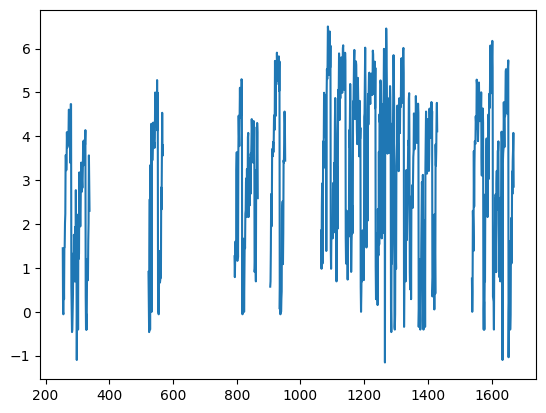

In [7]:
df["store_med_logpct_change_1"].plot()

In [5]:
df = load_X_y_data(Path("../output/data/train_top_store_15_item_clusters_sales_cyclical_features_X_1_day_y.parquet"), window_size=1, log_level="DEBUG")
df.head()

2025-07-17 15:11:06,228 - INFO - Loading data from ../output/data/train_top_store_15_item_clusters_sales_cyclical_features_X_1_day_y.parquet
2025-07-17 15:11:06,241 - INFO - Loaded data with shape (1354, 25)


,start_date,store_item,store_cluster,item_cluster,weight,store_med_day_1,item_med_day_1,store_med_change_1,item_med_change_1,store_med_logpct_change_1,...,weekofmonth_cos_1,monthofyear_sin_1,monthofyear_cos_1,paycycle_sin_1,paycycle_cos_1,season_sin_1,season_cos_1,y_sales_day_1,y_store_med_logpct_change_1,y_item_med_logpct_change_1
0,2014-01-02,10_1143685,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.309017,0.5,0.866025,0.743145,0.669131,-0.970064,0.242850,41.0,NaN,NaN
1,2014-01-03,10_1143685,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.309017,0.5,0.866025,0.951057,0.309017,-0.965740,0.259512,11.0,NaN,NaN
2,2014-01-04,10_1143685,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.309017,0.5,0.866025,0.994522,-0.104529,-0.961130,0.276097,44.0,NaN,NaN
3,2014-01-05,10_1143685,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.309017,0.5,0.866025,0.866025,-0.500000,-0.956235,0.292600,96.0,NaN,NaN
4,2014-01-06,10_1143685,0,0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.309017,0.5,0.866025,0.587785,-0.809017,-0.951056,0.309017,26.0,NaN,NaN


In [5]:
import torch
import pandas as pd
from typing import List

def dataloader_to_dataframe(loader_path: str, 
                            x_feature_cols: List[str],
                            label_cols: List[str], 
                            weight_col="weight") -> pd.DataFrame:
    """
    Load a saved DataLoader and convert its dataset into a pandas DataFrame.

    Parameters
    ----------
    loader_path : str
        Path to the saved DataLoader (.pt file).
    input_prefix : str
        Prefix to name input columns.
    target_col : str
        Column name for the target values.
    weight_col : str
        Column name for sample weights.

    Returns
    -------
    pd.DataFrame
        Combined DataFrame containing inputs, target, and weight.
    """
    data = torch.load(loader_path)

    loader = torch.utils.data.DataLoader(data.dataset, batch_size=32)

    all_x, all_y, all_w = [], [], []

    with torch.no_grad():
        for xb, yb, wb in loader:
            all_x.append(xb.cpu())
            all_y.append(yb.cpu())
            all_w.append(wb.cpu())

    x_tensor = torch.cat(all_x, dim=0)
    y_tensor = torch.cat(all_y, dim=0)
    w_tensor = torch.cat(all_w, dim=0)

    # Convert to numpy
    x_np = x_tensor.numpy()
    y_np = y_tensor.numpy()
    w_np = w_tensor.numpy()

    df = pd.DataFrame(x_np, columns=x_feature_cols)
    df2 = pd.DataFrame(y_np, columns=label_cols)
    df3 = pd.DataFrame(w_np, columns=[weight_col])
    df = pd.concat([df, df2, df3], axis=1)
    
    return df


In [13]:
meta_cols, x_sales_features, x_cyclical_features, x_feature_cols, x_to_log_features, x_log_features, label_cols, y_log_features, y_to_log_features = build_feature_and_label_cols(window_size=1)
print(
        meta_cols,
        x_sales_features,
        x_cyclical_features,
        x_feature_cols,
        x_to_log_features,
        x_log_features,
        label_cols,
        y_log_features,
        y_to_log_features,
    )

['start_date', 'store_item', 'store_cluster', 'item_cluster', 'weight'] ['store_med_day_1', 'item_med_day_1', 'store_med_change_1', 'item_med_change_1', 'store_med_logpct_change_1', 'item_med_logpct_change_1', 'sales_day_1'] ['dayofweek_sin_1', 'dayofweek_cos_1', 'weekofmonth_sin_1', 'weekofmonth_cos_1', 'monthofyear_sin_1', 'monthofyear_cos_1', 'paycycle_sin_1', 'paycycle_cos_1', 'season_sin_1', 'season_cos_1'] ['store_med_day_1', 'item_med_day_1', 'store_med_change_1', 'item_med_change_1', 'store_med_logpct_change_1', 'item_med_logpct_change_1', 'sales_day_1', 'dayofweek_sin_1', 'dayofweek_cos_1', 'weekofmonth_sin_1', 'weekofmonth_cos_1', 'monthofyear_sin_1', 'monthofyear_cos_1', 'paycycle_sin_1', 'paycycle_cos_1', 'season_sin_1', 'season_cos_1'] ['store_med_day_1', 'item_med_day_1', 'store_med_change_1', 'item_med_change_1', 'sales_day_1'] ['store_med_logpct_change_1', 'item_med_logpct_change_1'] ['y_sales_day_1', 'y_store_med_logpct_change_1', 'y_item_med_logpct_change_1'] ['y_sale

In [22]:
df = combine_loaders_to_dataframe(
    dataloader_dir=Path("../output/data/dataloader/"),
    x_feature_cols= x_feature_cols,
    label_cols= label_cols,
    store_cluster= 0,
    loader_type= "val",  # or "train"
    log_level= "INFO",
)

2025-07-24 11:44:31,871 - INFO - Loading ../output/data/dataloader
2025-07-24 11:44:31,874 - INFO - Loader type: val
2025-07-24 11:44:31,876 - INFO - Store cluster: 0
2025-07-24 11:44:31,876 - INFO - Item cluster: None
2025-07-24 11:44:31,878 - INFO - Loading 0_10_val_loader.pt (store_cluster=0, item_cluster=10)
2025-07-24 11:44:31,879 - INFO - Loading 0_10_val_loader.pt


2025-07-24 11:44:33,076 - INFO - Loading ../output/data/dataloader/0_10_val_meta.parquet
2025-07-24 11:44:33,179 - INFO - Loading 0_4_val_loader.pt (store_cluster=0, item_cluster=4)
2025-07-24 11:44:33,180 - INFO - Loading 0_4_val_loader.pt
2025-07-24 11:44:33,698 - INFO - Loading ../output/data/dataloader/0_4_val_meta.parquet


In [26]:
df

,start_date,store_item,store_cluster,item_cluster,weight,store_med_day_1,item_med_day_1,store_med_change_1,item_med_change_1,store_med_logpct_change_1,...,monthofyear_sin_1,monthofyear_cos_1,paycycle_sin_1,paycycle_cos_1,season_sin_1,season_cos_1,y_sales_day_1,y_store_med_logpct_change_1,y_item_med_logpct_change_1,weight
0,2014-01-03,23_1004551,0,10,1,0.876336,0.876336,0.059709,0.059709,0.358794,...,0.75,0.933013,0.978148,6.506919e-01,0.017126,0.629749,2.639057,0.481833,0.481833,1.0
1,2014-01-06,23_1004551,0,10,1,0.743335,0.743335,0.067434,0.067434,0.330371,...,0.75,0.933013,0.795511,8.549950e-02,0.024467,0.654502,1.386294,0.000000,0.000000,1.0
2,2014-01-07,23_1004551,0,10,1,0.724807,0.724807,0.048206,0.048206,0.255610,...,0.75,0.933013,0.604528,0.000000e+00,0.027197,0.662665,1.791759,0.000000,0.000000,1.0
3,2014-01-08,23_1004551,0,10,1,0.876336,0.876336,0.052214,0.052214,0.330371,...,0.75,0.933013,0.395471,5.960464e-08,0.030068,0.670779,1.945910,0.340368,0.340368,1.0
4,2014-01-09,23_1004551,0,10,1,0.724807,0.724807,0.078931,0.078931,0.358794,...,0.75,0.933013,0.204488,8.549958e-02,0.033077,0.678843,2.564949,0.684413,0.684413,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160007,2015-12-26,5_968432,0,4,1,0.831638,0.831638,0.181481,0.181481,0.502276,...,0.50,1.000000,0.500000,1.000000e+00,0.003884,0.562232,3.258096,0.284054,0.284054,1.0
160008,2015-12-27,5_968432,0,4,1,0.711115,0.711115,0.236214,0.236214,0.537510,...,0.50,1.000000,0.500000,1.000000e+00,0.005029,0.570762,3.367296,0.404792,0.404792,1.0
160009,2015-12-28,5_968432,0,4,1,0.666667,0.666667,0.264050,0.264050,0.555526,...,0.50,1.000000,0.500000,1.000000e+00,0.006321,0.579272,3.135494,0.136804,0.136804,1.0
160010,2015-12-29,5_968432,0,4,1,0.753284,0.753284,0.208629,0.208629,0.517284,...,0.50,1.000000,0.500000,1.000000e+00,0.007759,0.587758,3.401197,0.208478,0.208478,1.0


In [27]:
df.to_csv("../output/data/store_0df.csv", index=False)